# NLP for Movie Plots
*Hongyuan Jin, Eunseo Kang, Paige Harris, and Viki Papadakis*

## Purpose
We use natural language processing tools to find similar movies based on their summary plots.

## Methodology
- TF-IDF
- LDA

## WIP - improvements
Todos:
- replace character names with 'character'
- verify the clustering efficiency
-

## Results
Describe and comment the most important results.

## Suggested next steps
State suggested next steps, based on results obtained in this notebook.

# Setup

## Library import for Python
We import all the required Python libraries

In [205]:
import os
# print("Current Working Directory " , os.getcwd())
# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import plotly
import plotly.graph_objs as go
import plotly.offline as ply
plotly.offline.init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

import matplotlib as plt
# import matplotlib.pyplot as pplt

import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk.stem.snowball import SnowballStemmer
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

## Library import for R
We enable R in the notebook and import all the required libraries.

In [206]:
%load_ext rpy2.ipython

In [207]:
%%R
# install.packages("ggplot2", repos='http://cran.us.r-project.org', quiet=TRUE)
library(ggplot2)
library(fixest)
library(dplyr)
library(tidyr)
library(tidyverse)
# install.packages("lmtest")
library(lmtest)
library(sandwich)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


R[write to console]: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

R[write to console]: ✔ tibble  3.0.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0
✔ purrr   0.3.4     

R[write to console]: ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

R[write to console]: Loading required package: zoo

R[write to console]: 
Attaching package: ‘zoo’


R[write to console]: The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Local library import
We import all the required local libraries

In [15]:
# Include local library paths
import sys
# sys.path.append('path/to/local/lib') # uncomment and fill to import local libraries

# Import local libraries

# Data import
- Movie plots (*movies_df*)
    - source:

- Other movie attributes (*movie_other*)
    - source:

- Top star list data (*topstar*)
    - source:

## We first retrieve the data for movie summary plots.

In [208]:
movies_df = pd.read_csv('~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/wiki_movie_plots_deduped.csv')
movies_df.head(5)

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


## Data for Movie Plots
We subset the data for movies:
- Produced in the US
- Released between 1990 and 2010

In [211]:
# movies_df_sub = movies_df[(movies_df['Origin/Ethnicity']=="American")].reset_index(drop=True)
movies_df_sub = movies_df[(movies_df['Release Year']>=1990) &
                          (movies_df['Release Year']<=2010) &
                          (movies_df['Origin/Ethnicity']=="American")].\
    reset_index(drop=True)
movies_df_sub.head(5)
# 4631 movies to analyze

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1990,The Adventures of Ford Fairlane,American,Renny Harlin,"Andrew Dice Clay, Wayne Newton, Priscilla Pres...",comedy,https://en.wikipedia.org/wiki/The_Adventures_o...,Ford Fairlane (Andrew Dice Clay) is seen sitti...
1,1990,"After Dark, My Sweet",American,James Foley,"Jason Patric, Rachel Ward, Bruce Dern",mystery,"https://en.wikipedia.org/wiki/After_Dark,_My_S...","Ex-boxer Kevin ""Kid"" Collins is a drifter and ..."
2,1990,Air America,American,Roger Spottiswoode,"Mel Gibson, Robert Downey, Jr., Nancy Travis",comedy,https://en.wikipedia.org/wiki/Air_America_(film),"In late 1969, Billy Covington (Robert Downey J..."
3,1990,Alice,American,Woody Allen,"Mia Farrow, Joe Mantegna, William Hurt, Alec B...",comedy,https://en.wikipedia.org/wiki/Alice_(1990_film),Alice Tate is an upper-class New York housewif...
4,1990,Almost an Angel,American,John Cornell,"Paul Hogan, Elias Koteas, Charlton Heston",comedy,https://en.wikipedia.org/wiki/Almost_an_Angel,"Terry Dean (Paul Hogan), a professional burgla..."


In [229]:
movies_df_sub['Plot'].apply(len).describe()

count     4631.000000
mean      3194.705031
std       1759.174164
min         35.000000
25%       1916.500000
50%       3430.000000
75%       4205.000000
max      25123.000000
Name: Plot, dtype: float64

The above says that each plot has on average 3195 tokens (min: 35 and max: 25123).

# Data processing for movie plots

# NLP
We use TF-IDF and LDA to analyze the plot summaries.

## TF-IDF

In [230]:
stemmer = SnowballStemmer("english", ignore_stopwords=False)

normalized = []
totalvocab_tokenized = []
def normalize(X):
    normalized = []
    # totalvocab_tokenized = []
    for x in X:
        words = nltk.word_tokenize(x)
        normalized.append(' '.join([stemmer.stem(word) for word in words if re.match('[a-zA-Z]+', word)]))
        totalvocab_tokenized.extend(words)
    return normalized

pipe = Pipeline([
    ('normalize', FunctionTransformer(normalize, validate=False)),
    ('counter_vectorizer', CountVectorizer(
        max_df=0.8, max_features=200000,
        min_df=0.2, stop_words='english',
        ngram_range=(1, 3)
    )),
    ('tfidf_transform', TfidfTransformer())
])

tfidf_matrix = pipe.fit_transform([x for x in movies_df_sub['Plot']])
print(tfidf_matrix.shape)

(4631, 118)


In [231]:
similarity_distance = 1 - cosine_similarity(tfidf_matrix)
# similarity_distance

We test for finding similar movies for a given title

In [193]:
def find_similar(title):
    index = movies_df_sub[movies_df_sub['Title'] == title].index[0]
    vector = similarity_distance[index, :]
    most_similar = movies_df_sub.iloc[np.argsort(vector)[0:10], 0:2]
    return most_similar

### Example
The movies similar to *Madagascar (2005)* according to TF-IDF.

In [194]:
print(find_similar('Madagascar'))


      Release Year                           Title
3374          2005                      Madagascar
1194          1995      The Pebble and the Penguin
3607          2006                      Happy Feet
1775          1997                 Robinson Crusoe
2602          2001                Saving Silverman
3094          2004     Clifford's Really Big Movie
4497          2010                          Frozen
1269          1996  Alien Nation: The Enemy Within
1955          1998                      The Mighty
1306          1996           Cannibal! The Musical


### Cluster the movies based on the similarity metric from TF-IDF

In [233]:
from sklearn.cluster import KMeans

num_clusters = 23
# print(num_clusters)
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters_tfidf = km.labels_.tolist()

import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters_tfidf_first = km.labels_.tolist()

films = {'title': movies_df_sub["Title"], 'Release_year':  movies_df_sub["Release Year"],
         'Plot':  movies_df_sub['Plot'], 'cluster_tfidf_first': clusters_tfidf_first,
         'Director':  movies_df_sub['Director'], 'Genre':  movies_df_sub['Genre']}
# print(films)
frame = pd.DataFrame(data=films, columns=['title', 'cluster_tfidf_first', 'Genre', 'Release_year', 'Director'])
# print(frame)
print(frame['cluster_tfidf_first'].value_counts())
# # frame.to_csv(r'~/Dropbox/ImmInnHollywood/data/wiki_film_plot/plot_cluster.csv', index=False)

4     475
16    452
12    434
1     284
9     249
11    205
20    191
7     182
17    178
2     172
0     163
19    160
15    157
21    156
13    155
6     145
18    142
22    136
10    133
8     131
5     123
14    120
3      88
Name: cluster_tfidf_first, dtype: int64


#### Visualize the movies within a certain similarity range

In [247]:
frame_select = frame[['title', 'cluster_tfidf_first', 'Genre', 'Release_year']]
frame_select.sort_values(['cluster_tfidf_first']).groupby('cluster_tfidf_first').head(4)[:28]

,title,cluster_tfidf_first,Genre,Release_year
2226,The Talented Mr. Ripley,0,thriller,1999
1641,Fierce Creatures,0,comedy,1997
2856,44 Minutes: The North Hollywood Shoot-Out,0,action,2003
2867,Bad Santa,0,"comedy, crime",2003
457,Fifty/Fifty,1,comedy,1992
958,The Road to Wellville,1,"comedy, biography",1994
3545,The Death of Poe,1,horror,2006
3544,The Dead Girl,1,drama,2006
1086,Empire Records,2,"comedy, drama",1995
2385,Requiem for a Dream,2,drama,2000


top words in each cluster by TF-IDF

## LDA

TBU-Text explanation

In [248]:
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

processed_docs = movies_df_sub['Plot'].map(preprocess)
processed_docs[:10]

dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    # print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# from pprint import pprint
# for doc in corpus_tfidf:
#     pprint(doc)
#     break

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=23, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=23, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

mdiff, annotation = lda_model_tfidf.diff(lda_model_tfidf)
for index, score in sorted(lda_model_tfidf[bow_corpus[4]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

Topic: 0 
Words: 0.008*"peter" + 0.006*"barri" + 0.006*"kati" + 0.005*"mari" + 0.005*"sophi" + 0.004*"hotel" + 0.004*"alli" + 0.004*"simon" + 0.004*"aaron" + 0.004*"robot"
Topic: 1 
Words: 0.008*"michael" + 0.005*"bobbi" + 0.004*"carter" + 0.004*"jam" + 0.004*"anim" + 0.003*"maggi" + 0.003*"ross" + 0.003*"wade" + 0.003*"helen" + 0.003*"david"
Topic: 2 
Words: 0.010*"frank" + 0.007*"mike" + 0.005*"scott" + 0.005*"crew" + 0.004*"cole" + 0.003*"carl" + 0.003*"rick" + 0.003*"ship" + 0.003*"edward" + 0.002*"kenni"
Topic: 3 
Words: 0.020*"jimmi" + 0.010*"steve" + 0.006*"chris" + 0.005*"mari" + 0.005*"frank" + 0.004*"chip" + 0.003*"peter" + 0.003*"truck" + 0.003*"scott" + 0.003*"alan"
Topic: 4 
Words: 0.027*"jack" + 0.006*"frank" + 0.005*"rachel" + 0.004*"kate" + 0.004*"joseph" + 0.004*"ann" + 0.003*"stone" + 0.003*"beth" + 0.003*"matt" + 0.003*"traci"
Topic: 5 
Words: 0.007*"frank" + 0.006*"anna" + 0.005*"danni" + 0.003*"josh" + 0.003*"nanci" + 0.003*"oliv" + 0.003*"katherin" + 0.003*"larri"

## Import data for names and replace the character names with string 'character'

We find that the topic modeling is affected by the character names.
Below we will replace the names with the string 'Character'

*Data source: Social Security https://www.ssa.gov/oact/babynames/limits.html*

In [251]:
# filename = '~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/yob1980.txt'
# names = pd.read_csv(filename, delimiter = ",", header=None)
# names.columns = ["name", 'gender', 'count']
# names.head(5)
# names = names.sort_values('count')
# # keep the names with more than 1000 counts
# # names = names[names['count']>=100]
# print(names)

              name gender  count
19456          Zoe      M      5
11575      Natacia      F      5
11574      Nasreen      F      5
11573     Nashanda      F      5
11572       Narine      F      5
...            ...    ...    ...
12165        David      M  41920
12164        Jason      M  48170
12163  Christopher      M  49096
0         Jennifer      F  58379
12162      Michael      M  68704

[19457 rows x 3 columns]


In [200]:
# name = names.name.tolist()
# # print(name)
# 'Alice' in name

NameError: name 'names' is not defined

In [249]:
# load names.zip which has more names data txt files
import zipfile
with zipfile.ZipFile('/Users/aj/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/names.zip', 'r') as zip_ref:
    zip_ref.extractall('names/')

In [250]:
from pathlib import Path

allnames_files = Path('names').glob('yob*')
# print(allnames_files)
# allnames_files.sort()
allnames_list = list()

for f in allnames_files:
    step_1 = pd.read_csv(f, delimiter = ',', header=None)
    allnames_list.append(step_1)
allnames = pd.concat(allnames_list)
allnames.columns = ["name", 'gender', 'count']
allnames.shape
# drop gender and aggregate the counts groupby names
allnames.drop(['gender'], axis = 1, inplace = True)

In [251]:
# allnames.dtypes
allnames['totalcount'] = allnames['count'].\
    groupby(allnames['name']).transform('sum')
allnames.drop('count', axis = 1, inplace=True)
allnames.head
allnames.describe()

,totalcount
count,2.020863e+06
mean,3.401396e+04
std,1.910011e+05
min,5.000000e+00
25%,2.540000e+02
50%,9.560000e+02
75%,5.048000e+03
max,5.213689e+06


In [252]:
# drop duplicates and keep only the names with count larger than 100
allnames.drop_duplicates(subset='name', inplace= True)
allnames = allnames.sort_values(by = ['totalcount'], ascending=False)
# allnames = allnames[allnames['totalcount']>=5000]
allnames.head()
# there are in total 100364 unique names in the dataset, we will use \
# top 2000 names by the totalcount

,name,totalcount
3359,James,5213689
4466,John,5163958
5114,Robert,4849738
1567,Michael,4405274
3521,William,4159868


replace every name in the plot with character

In [233]:
# # DO NOT NEED TO RUN
# # ALERT: THIS CELL TAKES VERY LONG TO RUN
# # The name is a list from the names data of yob1980.txt
# for i in movies_df_sub.index:
#     for tag in name:
#         movies_df_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', movies_df_sub.Plot[i])
#
# # Plot.to_csv('test.csv', index=False)

TypeError: 'Series' object is not callable

In [ ]:
%%time
# # DO NOT NEED TO RUN
# ALERT: THIS CELL TAKES EVEN LONGER TO RUN
# The name is a list from the all names data
# there are in total 100364 unique names in the dataset, we will use \
# top 2000 names by the totalcount
name = allnames.name.to_list()
for i in movies_df_sub.index:
    for tag in name[:2000]:
        movies_df_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', movies_df_sub.Plot[i])

In [146]:
# save the new movie plot to data
movies_df_sub.to_csv('replaced_character_movie_plots.csv', index=False)

In [ ]:
# replace the plots with the rest of the names
for i in movies_df_sub.index:
    for tag in name[:400]:
        movies_df_sub.Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', movies_df_sub.Plot[i])

In [106]:
# %%time
# name = allnames.name.to_list()
# for tag in name[:100]:
#     # print(tag)
#     nameexp = re.compile(r'\b'+tag+r'\b')
#     for i in movies_df_sub.index[:100]:
#         movies_df_sub.Plot[i] = nameexp.sub('Character', movies_df_sub.Plot[i])

CPU times: user 4.85 s, sys: 62.3 ms, total: 4.91 s
Wall time: 4.91 s


In [114]:
# %%time
# from multiprocessing import Pool
#
# name = allnames.name.to_list()
#
# def f(x):
#     for tag in name[:5]:
#         re.sub(r'\b' + tag + r'\b', 'Character', x)
#
# if __name__ == '__main__':
#     with Pool(4) as p:
#         p.map(f, movies_df_sub.Plot[:5])


KeyboardInterrupt: 

KeyboardInterrupt: 

TF-IDF with the updated plot summaries

load the data for updated plots

In [165]:
new_movies_df = pd.read_csv("replaced_character_movie_plots.csv")
new_movies_df.Plot[5]

'Character follows a large white rabbit down a "Rabbit-hole". She finds a tiny door. When she finds a bottle labeled "Drink me", she does, and shrinks, but not enough to pass through the door. She then eats something labeled "Eat me" and grows larger. She finds a fan when enables her to shrink enough to get into the "Garden" and try to get a "Dog" to play with her. She enters the "White Rabbit\'s tiny House," but suddenly resumes her normal size. In order to get out, she has to use the "magic fan."\r\nShe enters a kitchen, in which there is a cook and a woman holding a baby. She persuades the woman to give her the child and takes the infant outside after the cook starts throwing things around. The baby then turns into a pig and squirms out of her grip. "The Duchess\'s Cheshire Cat" appears and disappears a couple of times to Character and directs her to the Mad Hatter\'s "Mad Tea-Party." After a while, she leaves.\r\nThe Character invites Character to join the "ROYAL PROCESSION": a par

In [168]:
tfidf_matrix = pipe.fit_transform([x for x in new_movies_df['Plot']])
print(tfidf_matrix.shape)

from sklearn.cluster import KMeans

num_clusters = 23
# print(num_clusters)
km = KMeans(n_clusters=num_clusters)

km.fit(tfidf_matrix)

clusters_tfidf = km.labels_.tolist()

import joblib

joblib.dump(km, 'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

films = {'title': new_movies_df["Title"], 'Release_year':  new_movies_df["Release Year"],
         'Plot':  new_movies_df['Plot'], 'cluster': clusters_tfidf,
         'Director':  new_movies_df['Director'], 'Genre': new_movies_df['Genre']}
# print(films)
frame = pd.DataFrame(data=films, columns=['title', 'cluster', 'Genre', 'Release_year', 'Director'])
# print(frame)
print(frame['cluster'].value_counts())
# frame.to_csv(r'~/Dropbox/ImmInnHollywood/data/wiki_film_plot/plot_cluster.csv', index=False)

(17377, 79)
6     1559
12    1306
17    1145
16    1133
14     925
18     814
11     807
3      752
21     727
8      721
20     687
2      680
5      659
13     625
1      618
22     616
9      551
0      550
15     546
10     531
19     491
7      472
4      462
Name: cluster, dtype: int64


Word Cloud for the TF-IDF

In [202]:
from nltk.corpus import stopwords
plots = []
stop_words = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer

wordnet_lemmatizer = WordNetLemmatizer()
for words in new_movies_df.Plot:
    only_letters = re.sub("[^a-zA-Z]", " ", words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result] #lemmatizes the words i.e convert similar words to their
    # base form while still considering the context in which the words are used
    plots.append(' '.join(lemmas))

Word Cloud with all movie plots

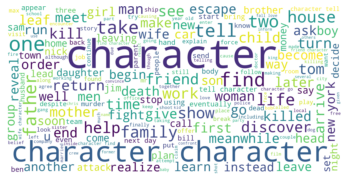

In [203]:
from wordcloud import WordCloud, STOPWORDS
unique_string=(" ").join(plots)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='white').generate(unique_string)
plt.pyplot.imshow(wordcloud, interpolation='bilinear')
plt.pyplot.axis("off")
plt.pyplot.show()

Word cloud with all movie plots for the most important words using countervectorizer

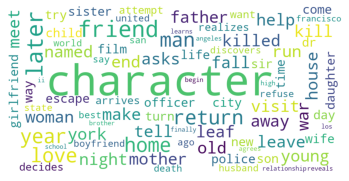

In [204]:
# the most important words in messages using countvectorizer
cv = CountVectorizer(analyzer = "word",stop_words = 'english', max_features = 100, ngram_range=(2,2))
important_words = cv.fit_transform(plots)
fig_words = cv.vocabulary_

#wordcloud for important words
unique_data=(" ").join(fig_words)
wordcloud = WordCloud(width = 1000, height = 500, background_color="white").generate(unique_data)
plt.pyplot.imshow(wordcloud)
plt.pyplot.axis("off")
plt.pyplot.show()
plt.pyplot.close()

LDA with the updated plot summaries

In [172]:
processed_docs = new_movies_df['Plot'].map(preprocess)
dictionary = gensim.corpora.Dictionary(processed_docs)
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 15:
        break

dictionary.filter_extremes(no_below=20, no_above=0.1, keep_n=100000)
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

for doc in corpus_tfidf:
    pprint(doc)
    break

lda_model = gensim.models.LdaMulticore(bow_corpus, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, num_topics=10, id2word=dictionary, passes=2, workers=4)
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

# mdiff, annotation = lda_model_tfidf.diff(lda_model_tfidf)
# for index, score in sorted(lda_model_tfidf[bow_corpus[4]], key=lambda tup: -1*tup[1]):
#     print("\nScore: {}\t \nTopic: {}".format(score, lda_model_tfidf.print_topic(index, 10)))

0 appear
1 assault
2 bartend
3 beer
4 begin
5 break
6 bucket
7 burst
8 cash
9 charact
10 custom
11 drink
12 dump
13 everybodi
14 eye
15 face
[(0, 0.13227954703913156),
 (1, 0.3790397673199794),
 (2, 0.374438855287237),
 (3, 0.2172397731360707),
 (4, 0.15173497760613988),
 (5, 0.1399498994366303),
 (6, 0.14142404420842042),
 (7, 0.14506212816523342),
 (8, 0.1793527179919929),
 (9, 0.13013718763569648),
 (10, 0.1350117256373554),
 (11, 0.3686891209949009),
 (12, 0.16259719029079714),
 (13, 0.26063277479936975),
 (14, 0.18848108896763566),
 (15, 0.20067540564150227),
 (16, 0.17125349985356006),
 (17, 0.1172126069805695),
 (18, 0.15900581156216126),
 (19, 0.19577237362575506),
 (20, 0.22411229640680644),
 (21, 0.10452823017669358),
 (22, 0.1628664933090168)]
Topic: 0 
Words: 0.005*"team" + 0.004*"jeff" + 0.003*"alien" + 0.002*"compani" + 0.002*"power" + 0.002*"gang" + 0.002*"parent" + 0.002*"agent" + 0.002*"smith" + 0.002*"bomb"
Topic: 1 
Words: 0.003*"gang" + 0.002*"chris" + 0.002*"boss" 

### Visualize the plot text (word cloud)

- Overall topic
- US-born director
- Foreign-born director
- Genre

## Import the data with other movie attributes

In [175]:
'Jeffrey' in allnames.name.to_list()

True

In [169]:
movies_other = pd.read_csv('~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/df_pstat234.csv')
movies_other.head(5)


,Name,Dirct1,Prodc1,Distributor,Cinematographer1,Actor1,Actor2,Actor3,Actor4,Actor5,Genre,us.year,us.quarter,domestic_bo,internaional_bo,budget_nielsen,budget_numbers,director_imm,director_continent,director_country,director_gender,director_race,international_bo
0,300 Year Weekend,Victor Stoloff,NaN,Cinerama Releasing Corporation,Joseph Brun,Michael Tolan,Sharon Laughlin,Roy Cooper,Gabriel Dell,M'el Dowd,Drama,1970,NaN,NaN,NaN,NaN,NaN,Foreign-born,NaN,Russian,NaN,NaN,NaN
1,A Bullet For Pretty Boy,Larry Buchanan,Larry Buchanan,NaN,NaN,Fabian,Jocelyn Lane,Astrid Warner,Michael Haynes,Adam Roarke,Action,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A Day at the Beach,Simon Hesera,Roman Polanski,Paramount Pictures,Gilbert Taylor,Mark Burns,Beatrice Edney,Peter Sellers,NaN,NaN,Drama,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A Man Called Sledge,Vic Morrow,Harry Bloom,Sony Pictures,Luigi Kuveiller,James Garner,Dennis Weaver,Claude Akins,John Marley,Laura Antonelli,Action,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A Run For the Money,Robert Canton,Robert Canton,NaN,Ken Van Sickle,Fred Dennis,Kim Pope,Bob Walden,Lisa Emmet,Eileen Dietz,Crime,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Import the data with big star names
*Source: https://www.imdb.com/list/ls058011111/?sort=list_order,asc&mode=detail*
*Scraped, code attached separately*

In [158]:
topstar = pd.read_csv('~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/topstar.csv')
topstar.head(5)

,Name
0,Robert De Niro
1,Jack Nicholson
2,Marlon Brando
3,Denzel Washington
4,Katharine Hepburn


## merge the data frames
- other movie attributes (*movies_other*)
- plot clustering with updated plots (*frame*)
- top star indicator (*topstar*)

,Name,Dirct1,Prodc1,Distributor,Cinematographer1,Actor1,Actor2,Actor3,Actor4,Actor5,Genre,us.year,us.quarter,domestic_bo,internaional_bo,budget_nielsen,budget_numbers,director_imm,director_continent,director_country,director_gender,director_race,international_bo
0,300 Year Weekend,Victor Stoloff,NaN,Cinerama Releasing Corporation,Joseph Brun,Michael Tolan,Sharon Laughlin,Roy Cooper,Gabriel Dell,M'el Dowd,Drama,1970,NaN,NaN,NaN,NaN,NaN,Foreign-born,NaN,Russian,NaN,NaN,NaN
1,A Bullet For Pretty Boy,Larry Buchanan,Larry Buchanan,NaN,NaN,Fabian,Jocelyn Lane,Astrid Warner,Michael Haynes,Adam Roarke,Action,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,A Day at the Beach,Simon Hesera,Roman Polanski,Paramount Pictures,Gilbert Taylor,Mark Burns,Beatrice Edney,Peter Sellers,NaN,NaN,Drama,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,A Man Called Sledge,Vic Morrow,Harry Bloom,Sony Pictures,Luigi Kuveiller,James Garner,Dennis Weaver,Claude Akins,John Marley,Laura Antonelli,Action,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,A Run For the Money,Robert Canton,Robert Canton,NaN,Ken Van Sickle,Fred Dennis,Kim Pope,Bob Walden,Lisa Emmet,Eileen Dietz,Crime,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,A.K.A. Cassius Clay,Jim Jacobs,William Cayton,NaN,Isidore Mankofsky,NaN,NaN,NaN,NaN,NaN,Documentary,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,About Me: A Musical,Robert Frank,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Experimental,1971,NaN,NaN,NaN,NaN,NaN,Native-born,North America (US),US,NaN,NaN,NaN
7,Adam at 6 A.M.,Robert Scheerer,Rick Rosenberg,National General Pictures,Charles Rosher Jr.,Michael Douglas,Lee Purcell,Joe Don Baker,Grayson Hall,Charles Aidman,Drama,1970,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Airport,George Seaton,Ross Hunter,Universal,Ernest Laszlo,Burt Lancaster,Dean Martin,Jean Seberg,Jacqueline Bisset),George Kennedy,Thriller,1970,NaN,NaN,NaN,10000000.0,NaN,Native-born,North America (US),US,NaN,NaN,NaN
9,Alex in Wonderland,Paul Mazursky,Larry Tucker,NaN,Laszlo Kovacs,Donald Sutherland,Ellen Burstyn,Meg Mazursky,Glenna Sergent,Viola Spolin,Comedy,1970,NaN,NaN,NaN,NaN,NaN,Native-born,North America (US),US,NaN,NaN,NaN


generate top star indicator for each movie if one of the main actors is on the list of top star from the above source.

In [176]:
%%R

movies_other = read.csv('~/Dropbox/Course/PSTAT234/spr21/pstat234-final-project/df_pstat234.csv')
movies_other[1, ]

              Name         Dirct1 Prodc1                    Distributor
1 300 Year Weekend Victor Stoloff   <NA> Cinerama Releasing Corporation
  Cinematographer1        Actor1          Actor2     Actor3       Actor4
1      Joseph Brun Michael Tolan Sharon Laughlin Roy Cooper Gabriel Dell
     Actor5 Genre us.year us.quarter domestic_bo internaional_bo budget_nielsen
1 M'el Dowd Drama    1970         NA          NA              NA             NA
  budget_numbers director_imm director_continent director_country
1             NA Foreign-born               <NA>         Russian 
  director_gender director_race international_bo
1            <NA>          <NA>               NA


## Exploratory analysis

TBU

*with figures and summary statistics*

In [43]:
%%R
# -i df -w 5 -h 5 --units in -r 200
# import df from global environment
# make default figure size 5 by 5 inches with 200 dpi resolution

NULL


# Regression analysis


In [188]:
%%R
fit1 = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~ director_imm + director_gender + log(1+budget_nielsen)  | us.year + Genre + Distributor, data =movies_other)
summary(fit1)

# fit2 = feols(log(international_bo + sqrt(1+international_bo^2)) ~ director_imm + log(1+budget_numbers) | us.year + Genre + Distributor, movies_other)
# summary(fit2)

R[write to console]: NOTE: 21,559 observations removed because of NA values (LHS: 15,404, RHS: 21,248, Fixed-effects: 7,917).

R[write to console]: Warning:
R[write to console]:  In print.fixest(object, useS4 = FALSE):
 'useS4' is not a valid argument of function print.fixest (fyi, some of
its main arguments are 'n', 'type', 'se' and 'cluster').



OLS estimation, Dep. Var.: log(domestic_bo + sqrt(1 + domestic_bo^2))
Observations: 3,319 
Fixed-effects: us.year: 40,  Genre: 21,  Distributor: 268
Standard-errors: Clustered (us.year) 
                        Estimate Std. Error   t value    Pr(>|t|)    
director_immNative-born 0.329304   0.067021  4.913500 1.60000e-05 ***
director_genderMale     0.000707   0.142389  0.004966 9.96063e-01    
log(1 + budget_nielsen) 0.700227   0.052000 13.466000 3.02000e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-likelihood: -5,967.91   Adj. R2: 0.64172 
                          R2-Within: 0.16848 


In [189]:
%%R
fit11st = feols(log(domestic_bo + sqrt(1+domestic_bo^2)) ~ log(1+budget_nielsen) + director_gender | us.year + Genre + Distributor, data =movies_other)
summary(fit11st)

R[write to console]: NOTE: 21,330 observations removed because of NA values (LHS: 15,404, RHS: 20,927, Fixed-effects: 7,917).

R[write to console]: Warning:
R[write to console]:  In print.fixest(object, useS4 = FALSE):
 'useS4' is not a valid argument of function print.fixest (fyi, some of
its main arguments are 'n', 'type', 'se' and 'cluster').



OLS estimation, Dep. Var.: log(domestic_bo + sqrt(1 + domestic_bo^2))
Observations: 3,548 
Fixed-effects: us.year: 40,  Genre: 21,  Distributor: 315
Standard-errors: Clustered (us.year) 
                        Estimate Std. Error   t value    Pr(>|t|)    
log(1 + budget_nielsen) 0.676808   0.050244 13.471000 2.98000e-16 ***
director_genderMale     0.016215   0.134817  0.120277 9.04881e-01    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1
Log-likelihood: -6,415.09   Adj. R2: 0.66227 
                          R2-Within: 0.16042 


In [190]:
%%R
fit11 = lm(resid(fit11st) ~ director_imm, movies_other)
summary(fit11)
# fit11cl = coeftest(fit11, vcov. = vcovCL, cluster = ~cluster)
# fit11cl

# fit21st = feols(log(intNationbo_numbers + sqrt(1+intNationbo_numbers^2)) ~ log(1+budget_numbers)| us.year + Genre.Recode + Distributor, df)
# summary(fit21st)
# fit22 = lm(resid(fit21st) ~ dir1.imm, df)
# fit22cl = coeftest(fit22, vcov. = vcovCL, cluster = ~cluster)
# fit22cl



Call:
lm(formula = resid(fit11st) ~ director_imm, data = movies_other)

Residuals:
    Min      1Q  Median      3Q     Max 
-9.2280 -0.5893  0.1672  0.8513  6.3669 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             -0.16719    0.04340  -3.853 0.000119 ***
director_immNative-born  0.27472    0.05363   5.122 3.19e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.469 on 3317 degrees of freedom
  (21559 observations deleted due to missingness)
Multiple R-squared:  0.007848,	Adjusted R-squared:  0.007548 
F-statistic: 26.24 on 1 and 3317 DF,  p-value: 3.193e-07



# References
We report here relevant references:
1. author1, article1, journal1, year1, url1
2. author2, article2, journal2, year2, url2
3. NLTK: @book{bird2009natural,
  title={Natural language processing with Python: analyzing text with the natural language toolkit},
  author={Bird, Steven and Klein, Ewan and Loper, Edward},
  year={2009},
  publisher={" O'Reilly Media, Inc."}
}


# Appendix

example showing how the preprocessing works

In [30]:
doc_sample = movies_df_sub[movies_df_sub['Title'] == 'Madagascar'].values[0][7]
print(doc_sample)
print('original document: ')
words = []
for word in doc_sample.split(' '):
    words.append(word)
print(words)
print('\n\n tokenized and lemmatized document: ')
print(preprocess(doc_sample))


At the Central Park Zoo, Marty the zebra is celebrating his tenth birthday, but has grown bored with his daily routine and longs to experience the wild. Marty's best friend is Alex the lion, who enjoys showing off for the public and his celebrity status as "the King of New York City". Alex attempts to cheer Marty up, but Marty, still unsatisfied, gets some tips from the zoo's penguins—Skipper, Kowalski, Rico, and Private—who are trying to escape the zoo, and follows them out. Alex, Melman the giraffe, and Gloria the hippopotamus pursue Marty in an attempt to convince him to return. The four, along with the penguins and two chimpanzees named Mason and Phil, find themselves at Grand Central Station, where they are quickly sedated via tranquillizer gun when Alex's attempt to communicate with humans is mistaken for aggression. The zoo, under pressure from anti-captivity activists, is forced to ship the escaped animals by sea to a Kenyan wildlife preserve. During their travels, the penguins

testing with name replacement

In [ ]:
miniplot = movies_df_sub.Plot[5]
# miniplot.head()

In [ ]:
# print(miniplot)
# tags = ['Alice', 'John']
for tag in names:
    miniplot = miniplot.replace(tag, 'Character')

print(miniplot)

In [ ]:
for tag in name:
    miniplot = re.sub(r'\b' + tag + r'\b', 'Character', miniplot)
print(miniplot)

In [ ]:
Plot = movies_df_sub.Plot.sample(10)
for i in Plot.index:
    for tag in name:
        Plot[i] = re.sub(r'\b' + tag + r'\b', 'Character', Plot[i])
print(Plot)
# Plot.to_csv('test.csv', index=False)

In [ ]:
'Grace' in name